# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [RAMP on cell phenotyping](http://www.ramp.studio/problems/mouse_cytometry): population identification from single cell data

## Introduction


Tissue samples are mixtures of several distinct cell types each of which performs certain activities for the maintenance of proper tissue functioning. To carry out these activites cells of each type are programmed to produce specific sets of membrane proteins, known as markers. These markers are usually involved in activities such as communication, adhesion, or metabolism. The specificity of a marker to an activity and, concomitantly, to a cell type makes it ideal to use for separating cells into different populations. A caveat to this task is that some surface markers will often be present on more than one cell populations.

In this context, cell phenotyping is the analysis of such heterogeneous populations of cells based on the types of proteins installed on their surfaces (phenotype). The purpose of this process is to identify the presence and proportions of the various populations of interest and enable the determination of their functions in tissues. As such, cell phenotyping has led to the significant improvement of our understanding of biological mechanisms and their association with disease. 

Single-cell technologies, such as flow/mass cytometry, are able to detect and objectively measure the abundance of cell markers in hundreds of thousands of individual cells and acquire data about dozens of them in a matter of seconds. Flow cytometry platforms, for example, are being used for decades now as a research tool to distinguish different cell types in mixed populations by measuring up to 20 markers on a cell-by-cell basis. More recently, the advent of mass cytometry has pushed this limit up to more than 40 parameters, boosting the potential resolution of phenotyping.

Until today, however, the analysis of the resulting high-dimensional datasets relies on the subjective and time-consuming _gating_, that is, a manual labeling procedure whereby cells are iteratively partitioned into populations through visual inspection by an expert of one-dimensional histogram or two-dimensional scatter plots at a time. This inefficiency to handle high-dimensional data has resulted in a growing interest for the development of robust computational methods that are able to identify interesting cell populations in an automated manner. In response to such need, the goal of this challenge is to develop prediction models able to **identify cell populations from single cell mass cytometry data**.


## Data synopsis

The data is from [Samusik et al.](https://www.nature.com/nmeth/journal/v13/n6/full/nmeth.3863.html) where, 38 surface markers (_features_) were measured in cells from the the bone marrow of healthy mice. The samples were analyzed and independently hand-gated by experts to identify 24 immune cell populations (_classes_).

We provide a random subset of 160K cell samples (from the [>500K publicly available](https://www.dropbox.com/sh/fx83o71jmjac554/AAA5yyvE_3dKRnvQM5VoJPLba?dl=0)).

Part of these data are saved in the files _train.csv_ and _test.csv_ as follows (<i>n_samples</i> being the number of cell samples, <i>n_feat</i> being the number of features/markers and <i>cell_type</i> being class labels):

<ul>
<li> each <b>row</b> corresponds to a cell sample</li>
<li> <b>columns 1 to 38</b> contain the abundance levels of the 38 surface markers (features). Dimensions: (n_samples, n_feat)</li>
<li><b>column 39 (<i>cell_type</i>)</b> contains the population label that each cell corresponds to according to manual gating by experts. Twenty four possible values. Dimensions: (n_samples, 1)</li>
</ul>

## Data-analysis suggestions

The data provided have been normalized using internal cytometry standards. However, cytometry data are naturally log-normal, hence, a log or log-like scale is typically used to visualize and interpret the data. Commonly used scales include inverse hyperbolic sine (arcsinh), logarithmic, and logicle (also referred to as ‘‘bi-exponential’’) scales [Diggins,et al.](https://www.ncbi.nlm.nih.gov/pubmed/25979346).

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.options.display.max_columns = 40

## Exploratory data analysis

### Loading the data

In [4]:
train_filename = 'data/train.csv.gz'
data = pd.read_csv(train_filename)
y_df = data['cell type']
X_df = data.drop(['cell type'], axis=1)
X_df.head(5)

,CD45_2,Ly6G,IgD,CD11c,F480,CD3,NKp46,CD23,CD34,CD115,CD19,CD317,CD8,Ly6C,CD4,CD11b,CD27,CD16_32,SiglecF,Foxp3,B220,CD5,FceR1a,TCRgd,CCR7,Sca1,CD49b,cKit,CD150,CD25,TCRb,CD43,CD64,CD138,CD103,IgM,CD44,MHCII
0,5.184107,-0.614249,16.254227,1.128962,-0.294390,-0.257445,2.185687,1.691536,0.488122,4.966866,17.581703,-0.569669,-0.331235,-0.226878,-0.344648,-0.345967,-0.014072,37.040405,1.075191,2.253999,86.695564,-0.266084,0.384504,-0.383413,0.612064,5.972107,0.785341,0.771280,-0.326184,0.255916,-0.730248,-0.377115,-0.451360,0.414938,1.018010,47.419044,13.165092,144.117569
1,26.108330,-0.143993,20.763287,-0.727420,-0.525899,-0.331602,2.568386,0.424135,-0.172433,-0.638150,9.989503,-0.186103,-0.342890,-0.384077,-0.548422,-0.316043,-0.619742,16.956970,-0.069873,-0.787566,10.885949,-0.857974,4.181842,-0.515586,-0.406529,19.277637,-0.825047,-0.601090,2.094285,0.495830,-0.828456,-0.423263,3.131299,-0.347129,-0.494209,14.892539,3.116287,153.527084
2,1.998982,3.593766,-0.174089,-0.074486,1.884863,-0.772508,-0.195184,-0.102560,-0.188266,3.557146,-0.279910,0.099656,-0.767110,-0.709119,-0.422201,4.086310,-0.017603,0.071415,0.530981,4.106629,0.356871,14.079478,-0.754099,1.358163,1.129240,2.878189,-0.561281,39.050819,0.271382,0.335835,-0.023304,2.570186,-0.606843,-0.180119,-0.572884,6.078991,100.899887,10.146564
3,7.558946,-0.317426,29.027504,-0.490670,-0.761016,0.240243,-0.022701,2.290725,-0.167272,-0.035398,12.393232,-0.579551,-0.547592,-0.194719,-0.143832,1.355173,-0.717659,9.838818,0.731562,0.755950,165.188660,0.079020,0.216597,-0.596524,-0.498703,3.479736,-0.631879,-0.663007,-0.617559,-0.128783,1.313777,-0.090054,-0.476902,-0.566708,0.548303,71.261215,4.854009,514.531860
4,6.346709,-0.381714,-0.246489,-0.035979,7.812408,0.783094,0.420766,-0.345945,-0.389636,6.196233,1.221561,-0.400435,-0.507851,159.850327,-0.233085,60.301483,2.634705,72.398682,9.063648,-0.759565,-0.769704,1.116173,1.225353,0.459268,-0.296914,-0.501460,0.084222,-0.398124,0.575038,2.405784,-0.592862,8.540835,-0.045285,0.516026,-0.215256,1.912416,123.579239,3.622238


In [5]:
y_df

0         IgDpos IgMpos B cells
1         IgDpos IgMpos B cells
2                           MEP
3         IgDpos IgMpos B cells
4           Classical Monocytes
5           Classical Monocytes
6         IgDpos IgMpos B cells
7         IgDpos IgMpos B cells
8             IgM- IgD- B-cells
9           IgD- IgMpos B cells
10          Classical Monocytes
11        IgDpos IgMpos B cells
12        IgDpos IgMpos B cells
13       Intermediate Monocytes
14                  Eosinophils
15          Classical Monocytes
16        IgDpos IgMpos B cells
17       Intermediate Monocytes
18        IgDpos IgMpos B cells
19          Classical Monocytes
20        IgDpos IgMpos B cells
21                         pDCs
22            IgM- IgD- B-cells
23                  Eosinophils
24        IgDpos IgMpos B cells
25                          MEP
26        IgDpos IgMpos B cells
27          Classical Monocytes
28       Intermediate Monocytes
29                     NK cells
                  ...          
19970   

In [6]:
data.describe()

,CD45_2,Ly6G,IgD,CD11c,F480,CD3,NKp46,CD23,CD34,CD115,CD19,CD317,CD8,Ly6C,CD4,CD11b,CD27,CD16_32,SiglecF,Foxp3,B220,CD5,FceR1a,TCRgd,CCR7,Sca1,CD49b,cKit,CD150,CD25,TCRb,CD43,CD64,CD138,CD103,IgM,CD44,MHCII
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,13.709700,1.879270,11.246772,0.696559,7.282648,1.957412,0.841610,0.635174,3.832098,3.274759,2.779092,5.080735,3.900572,45.857385,9.140277,61.185287,4.328650,64.579647,9.675808,0.727527,40.647017,9.656876,1.219676,0.039424,1.062334,38.720149,2.168544,4.746880,0.518617,0.321323,2.377227,20.057795,6.546918,0.872347,0.232923,47.141063,111.798262,168.860568
std,12.750946,2.973617,25.812864,4.330598,20.691196,9.073060,2.361161,2.429690,15.530291,5.547949,5.616888,26.281349,23.614836,86.288165,51.870401,104.029546,15.949272,82.743606,26.003295,2.142129,71.629270,48.712210,5.298974,1.294017,5.071636,187.575628,13.630346,27.129166,1.937042,1.903206,11.634843,55.730820,22.201841,2.625191,1.451478,225.841267,117.386742,358.342212
min,0.689910,-0.939096,-0.953296,-0.955921,-0.963544,-0.957609,-0.956368,-0.962759,-0.960851,-0.951100,-0.952782,-0.955540,-0.951181,-0.952593,-0.941269,-0.956041,-0.953131,-0.934012,-0.961858,-0.953011,-0.959281,-0.952529,-0.953412,-0.953304,-0.955424,-0.959300,-0.950866,-0.956529,-0.956209,-0.951548,-0.956899,-0.943958,-0.945808,-0.955067,-0.960537,-0.948119,-0.929574,-0.934934
25%,5.367285,0.011745,-0.450860,-0.533870,-0.037877,-0.497673,-0.436653,-0.522581,-0.202065,0.196615,-0.412958,-0.527239,-0.510720,-0.171324,-0.405624,-0.116031,-0.375971,13.567613,0.202856,-0.425482,-0.232208,0.139392,-0.317892,-0.551790,-0.354834,-0.183604,-0.516603,-0.479171,-0.475858,-0.517472,-0.495175,-0.102233,0.345299,-0.389858,-0.512231,0.004675,11.378628,2.912283
50%,10.265320,1.120865,-0.068927,-0.222152,1.704720,-0.161042,-0.027267,-0.198229,0.746728,1.649753,0.101136,-0.210559,-0.184942,3.930560,0.100846,7.096601,0.244438,37.054848,1.879903,-0.023726,1.471228,1.427473,0.354039,-0.262277,0.251846,0.860442,-0.192495,-0.122813,-0.112282,-0.197644,-0.141102,1.948316,2.086803,0.129269,-0.187583,1.842999,77.300793,9.495035
75%,17.749564,2.879429,3.021362,0.460411,6.907265,0.643786,1.134859,0.609988,2.916438,4.366428,3.688090,0.441300,0.593220,56.337713,1.891947,80.644081,2.270544,85.197489,5.478598,1.008633,50.802129,3.915237,1.579124,0.100581,1.493933,5.340081,0.586520,1.049539,0.751492,0.456671,0.651429,14.516475,5.898952,1.236123,0.470472,31.044620,184.754883,151.142109
max,194.885208,139.741837,317.892731,199.311951,559.553528,193.033981,44.262444,30.886175,350.304291,223.163712,70.145615,894.920715,527.528198,933.681641,1368.364990,1206.356445,315.321930,1827.831299,443.213684,49.981319,586.384155,1211.079468,419.073181,42.786957,616.684631,3131.254883,374.059692,764.139282,104.054375,55.070110,312.699097,986.681458,1163.531738,99.138710,51.372639,7097.400391,1860.849365,5880.458496


In [7]:
data.count()

CD45_2       20000
Ly6G         20000
IgD          20000
CD11c        20000
F480         20000
CD3          20000
NKp46        20000
CD23         20000
CD34         20000
CD115        20000
CD19         20000
CD317        20000
CD8          20000
Ly6C         20000
CD4          20000
CD11b        20000
CD27         20000
CD16_32      20000
SiglecF      20000
Foxp3        20000
B220         20000
CD5          20000
FceR1a       20000
TCRgd        20000
CCR7         20000
Sca1         20000
CD49b        20000
cKit         20000
CD150        20000
CD25         20000
TCRb         20000
CD43         20000
CD64         20000
CD138        20000
CD103        20000
IgM          20000
CD44         20000
MHCII        20000
cell type    20000
dtype: int64

In [8]:
np.unique(y_df)

array(['B-cell Frac A-C (pro-B cells)', 'Basophils', 'CD4 T cells',
       'CD8 T cells', 'CLP', 'CMP', 'Classical Monocytes', 'Eosinophils',
       'GMP', 'HSC', 'IgD- IgMpos B cells', 'IgDpos IgMpos B cells',
       'IgM- IgD- B-cells', 'Intermediate Monocytes', 'MEP', 'MPP',
       'Macrophages', 'NK cells', 'NKT cells', 'Non-Classical Monocytes',
       'Plasma Cells', 'gd T cells', 'mDCs', 'pDCs'], dtype=object)

### Predicting cell type

The goal is to predict the cell type. Let us group the data according to the `cell type` columns:

In [9]:
counts = data.groupby('cell type').count()['CD45_2']
counts.sort_values()

cell type
HSC                                 2
gd T cells                         13
CLP                                24
MPP                                47
mDCs                               49
Plasma Cells                       58
CMP                                66
NK cells                          119
Macrophages                       120
B-cell Frac A-C (pro-B cells)     151
Basophils                         160
MEP                               197
CD4 T cells                       224
GMP                               228
NKT cells                         309
Non-Classical Monocytes           326
CD8 T cells                       488
IgM- IgD- B-cells                 799
pDCs                              979
IgD- IgMpos B cells              1957
Eosinophils                      2108
Intermediate Monocytes           3290
Classical Monocytes              3851
IgDpos IgMpos B cells            4435
Name: CD45_2, dtype: int64

The class distribution is very unbalanced which explains why we will measure the performance with balanced accuracy aka macro-averaged recall.

### Some plots

#### Features densities and co-evolution
A scatterplot matrix allows us to visualize:
* on the diagonal, the density estimation for each feature
* on each of the off-diagonal plots, a scatterplot between two features. Each dot represents an instance.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  import sys


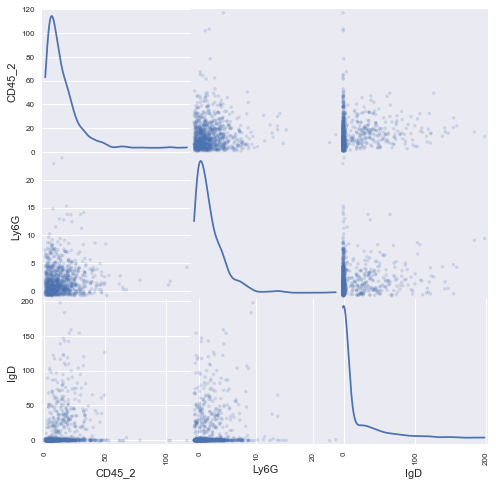

In [19]:
from pandas.tools.plotting import scatter_matrix

data_plot = data[['CD45_2', 'Ly6G', 'IgD', 'cell type']].iloc[
    np.random.choice(len(data), 1000)]

scatter_matrix(data_plot, alpha=0.2,
               figsize=(8, 8), diagonal='kde');

#### Plot the bivariate distributions and marginals of two variables 

Another way of visualizing relationships between variables is to plot their bivariate distributions.

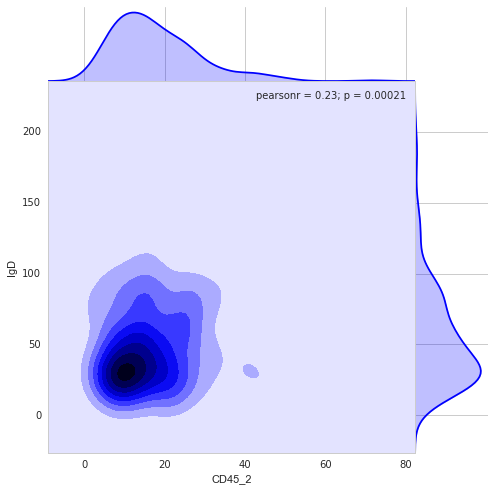

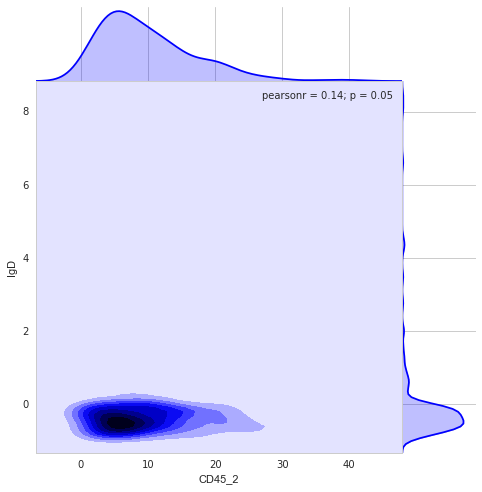

In [31]:
sns.set()
sns.set_style("whitegrid")
sns.jointplot(data_plot['CD45_2'][data_plot['cell type'] == 'IgDpos IgMpos B cells'],
              data_plot['IgD'][data_plot['cell type'] == 'IgDpos IgMpos B cells'],
              kind="kde", size=7, space=0, color="b");

sns.jointplot(data_plot['CD45_2'][data_plot['cell type'] == 'Classical Monocytes'],
              data_plot['IgD'][data_plot['cell type'] == 'Classical Monocytes'],
              kind="kde", size=7, space=0, color="b");


## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor`, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features). 
* a class `Classifier` to predict survival

### Feature extractor

The feature extractor implements a `transform` member function. It is saved in the file [`submissions/starting_kit/feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py). It receives the pandas dataframe `X_df` defined at the beginning of the notebook. It should produce a numpy array representing the extracted features, which will then be used for the classification.  

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [32]:
%%file submissions/starting_kit/feature_extractor.py
class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_array = X_df.values
        return X_array



Overwriting submissions/starting_kit/feature_extractor.py


### Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf` in `__init__`, then calls its `fit` and `predict_proba` functions in the corresponding member funtions.

In [38]:
%%file submissions/starting_kit/classifier.py
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.clf = RandomForestClassifier(
            n_estimators=2, max_leaf_nodes=2, random_state=61)
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)



Overwriting submissions/starting_kit/classifier.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `classifier.py` and `feature_extractor.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [39]:
!ramp_test_submission

Testing Cell population identification from single-cell mass cytometry data
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	train bac = 0.123
	valid bac = 0.123
	test bac = 0.128
	train accuracy = 0.572
	valid accuracy = 0.57
	test accuracy = 0.572
CV fold 1
	train bac = 0.123
	valid bac = 0.123
	test bac = 0.128
	train accuracy = 0.571
	valid accuracy = 0.571
	test accuracy = 0.573
CV fold 2
	train bac = 0.123
	valid bac = 0.123
	test bac = 0.129
	train accuracy = 0.572
	valid accuracy = 0.572
	test accuracy = 0.573
CV fold 3
	train bac = 0.123
	valid bac = 0.123
	test bac = 0.129
	train accuracy = 0.572
	valid accuracy = 0.571
	test accuracy = 0.573
CV fold 4
	train bac = 0.123
	valid bac = 0.123
	test bac = 0.128
	train accuracy = 0.569
	valid accuracy = 0.57
	test accuracy = 0.571
CV fold 5
	train bac = 0.123
	valid bac = 0.123
	test bac = 0.128
	train accuracy = 0.57
	valid accuracy = 0.571
	test accuracy = 0.572
CV fo

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [mouse cytometry](http://www.ramp.studio/events/mouse_cytometry) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/mouse_cytometry/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/mouse_cytometry/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/mouse_cytometry/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/mouse_cytometry/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train bac = 0.123 ± 0.0003
train accuracy = 0.571 ± 0.0012
valid bac = 0.123 ± 0.0002
valid accuracy = 0.571 ± 0.0006
test bac = 0.128 ± 0.0002
test accuracy = 0.572 ± 0.0008
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/mouse_cytometry/leaderboard)) is balanced accuracy aka macro-averaged recall, so the line that is relevant in the output of `ramp_test_submission` is `valid bac = 0.128 ± 0.0002`. When the score is good enough, you can submit it at the RAMP.

## Working in the notebook

When you are developing and debugging your submission, you may want to stay in the notebook and execute the workflow step by step. You can import `problem.py` and call the ingredients directly, or even deconstruct the code from [ramp-workflow](https://github.com/paris-saclay-cds/ramp-workflow).

In [40]:
import imp
problem = imp.load_source('', 'problem.py')

Get the training data.

In [41]:
X_train, y_train = problem.get_train_data()

Get the first cv fold, creating training and validation indices.

In [42]:
train_is, test_is = list(problem.get_cv(X_train, y_train))[0]
test_is

array([ 9650,  7918,  8375, ..., 17104, 12224, 16693])

Train your starting kit.

In [43]:
fe, clf = problem.workflow.train_submission(
    'submissions/starting_kit', X_train, y_train, train_is)

Get the full prediction (train and validation).

In [44]:
y_pred = problem.workflow.test_submission((fe, clf), X_train)

Print the training and validation scores.

In [45]:
score_function = problem.score_types[0]

`score_function` is callable, wrapping scikit-learn's `recall_score(..., average='macro')`. It expects the label index vectors, so it's easier if we wrap the predictions into `rampwf.prediction_types.multiclass` which does these transformations and call `score_function.score_function` which takes this type as input.

In [51]:
ground_truth = problem.Predictions(y_true=y_train)
prediction = problem.Predictions(y_pred=y_pred)

In [52]:
score_train = score_function.score_function(ground_truth, prediction, train_is)
print(score_train)

0.123362066154


In [53]:
score_valid = score_function.score_function(ground_truth, prediction, test_is)
print(score_valid)

0.122811637813


Get the independent test data.

In [54]:
X_test, y_test = problem.get_test_data()

Test the submission on it.

In [55]:
y_test_pred = problem.workflow.test_submission((fe, clf), X_test)

In [56]:
ground_truth_test = problem.Predictions(y_true=y_test)
prediction_test = problem.Predictions(y_pred=y_test_pred)

In [57]:
score_test = score_function.score_function(ground_truth_test, prediction_test)
print(score_test)

0.128267513215


If you want to execute training step by step, go to the [`feature_extractor_classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/feature_extractor_classifier.py), [`feature_extractor`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/feature_extractor.py), and [`classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/classifier.py) workflows and deconstruct them.

First load the submission files and instantiate the feature extractor and regressor objects.

In [58]:
feature_extractor = imp.load_source(
    '', 'submissions/starting_kit/feature_extractor.py')
fe = feature_extractor.FeatureExtractor()
classifier = imp.load_source(
    '', 'submissions/starting_kit/classifier.py')
clf = classifier.Classifier()

Select the training folds.

In [59]:
X_train_train_df = X_train.iloc[train_is]
y_train_train = y_train[train_is]

Fit the feature extractor.

In [60]:
fe.fit(X_train_train_df, y_train_train)

Transform the training dataframe into numpy array.

In [61]:
X_train_train_array = fe.transform(X_train_train_df)

Fit the classifier.

In [62]:
clf.fit(X_train_train_array, y_train_train)

Transform the _whole_ (training + validation) dataframe into a numpy array and compute the prediction.

In [63]:
X_train_array = fe.transform(X_train)
y_pred = clf.predict_proba(X_train_array)
ground_truth = problem.Predictions(y_true=y_train)
prediction = problem.Predictions(y_pred=y_pred)

Print the errors.

In [64]:
score_train = score_function.score_function(ground_truth, prediction, train_is)
print(score_train)

0.123362066154


In [65]:
score_valid = score_function.score_function(ground_truth, prediction, test_is)
print(score_valid)

0.122811637813


## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=mouse cytometry notebook).